# Step1. 데이터 확인

In [1]:
import os

data_path = 'cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


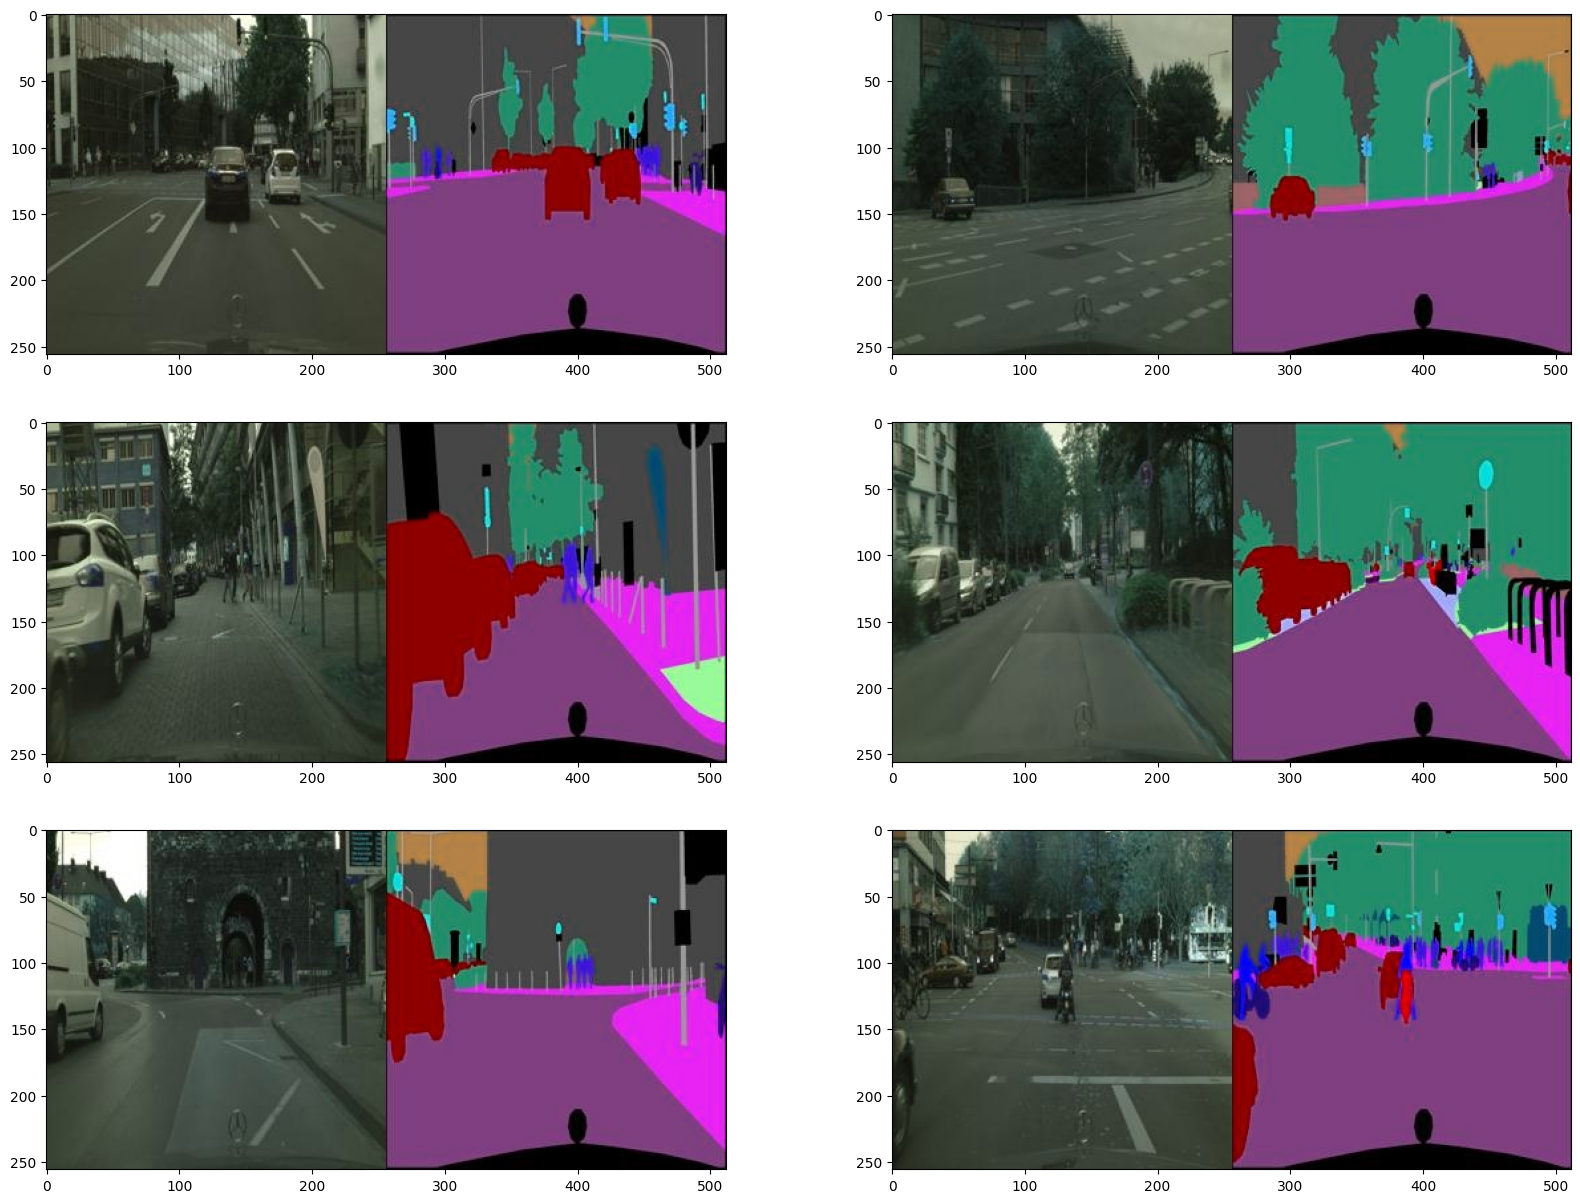

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# train data 중 6개만 랜덤하게 확인
plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(1000)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [4]:
# 이미지 크기 확인
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


# Step2. Augmentation

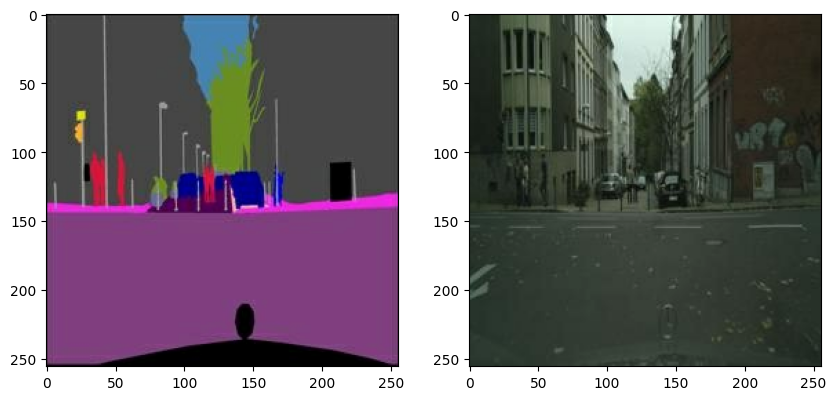

In [13]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

# seg image와 real img 나눠주기
def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    seg = img[:, w:, :]
    seg = tf.cast(seg, tf.float32)
    return normalize(seg), normalize(colored)

f = data_path + os.listdir(data_path)[1]
seg_img, real_img = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(seg_img))
plt.subplot(1,2,2); plt.imshow(denormalize(real_img))

In [23]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다.
def apply_augmentation(seg_img,real_img):
    stacked = tf.concat([seg_img,real_img], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, 'REFLECT')
    else:
        padded = tf.pad(stacked, _pad, 'CONSTANT', constant_values=1.)
        
    out = image.random_crop(padded, size=[256,256,6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]

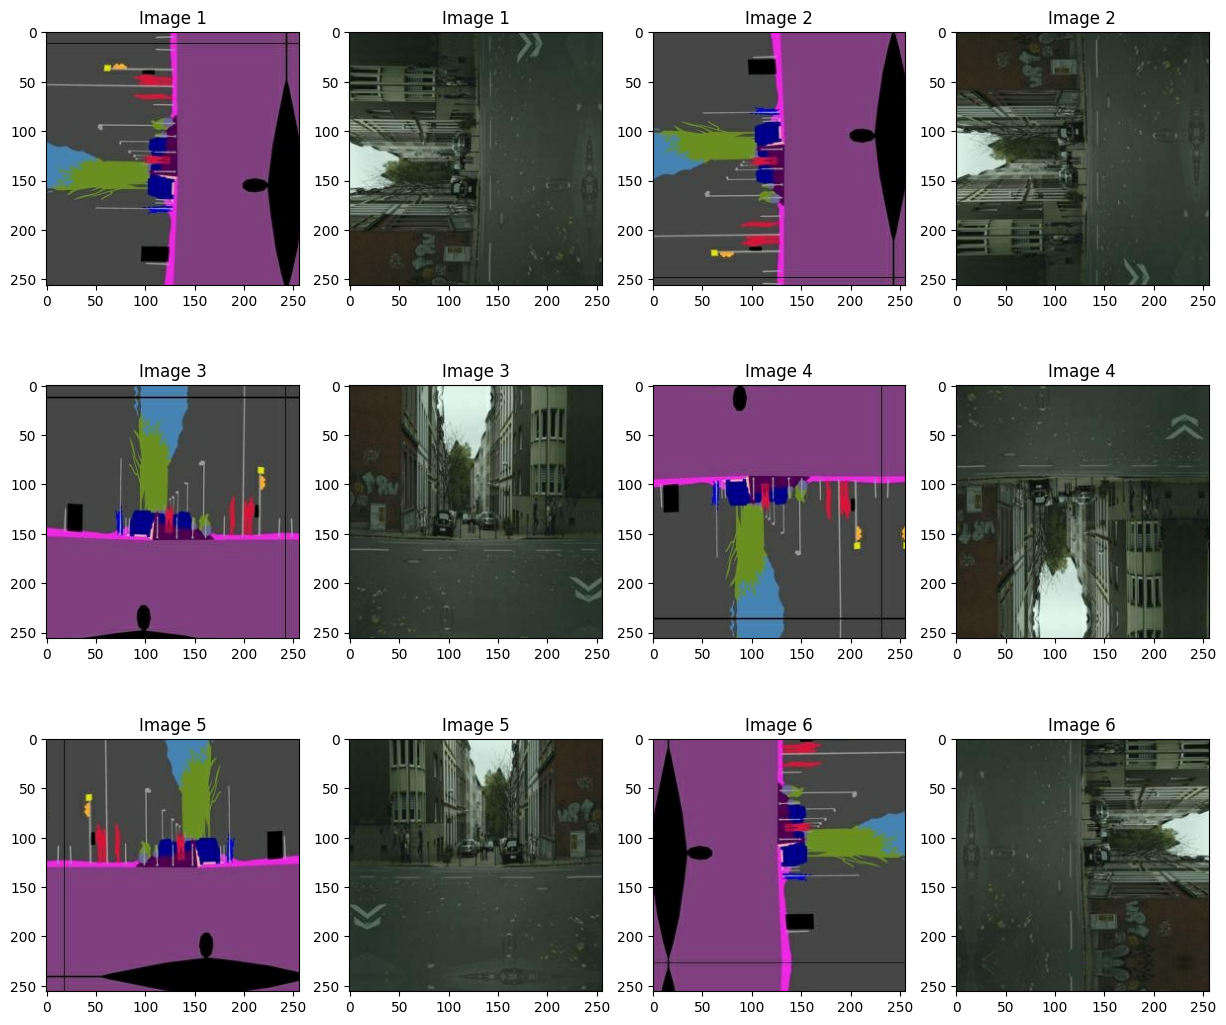

In [24]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_seg, augmented_real = apply_augmentation(seg_img, real_img)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_seg)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1)
    plt.imshow(denormalize(augmented_real)); plt.title(f"Image {img_n}")
    img_n += 1

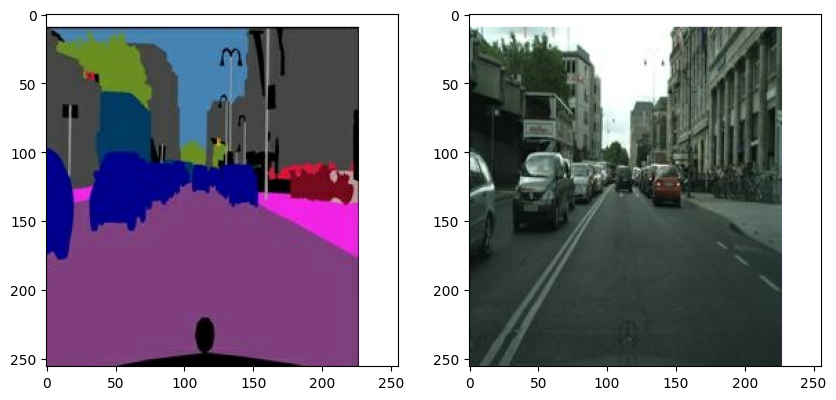

In [25]:
from tensorflow import data

# 모든 데이터set에 적용
def get_train(img_path):
    seg_img, real_img = load_img(img_path)
    seg_img, real_img = apply_augmentation(seg_img, real_img)
    return seg_img, real_img

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
seg_img, real_img = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5 

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(seg_img[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(real_img[0].astype(np.uint8))

# Step3. Generator구성

In [36]:
from tensorflow.keras import layers, Input, Model

# 블록 구성
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [41]:
# U-Net
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator,self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [42]:
UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_40 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_41 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_40[0][0]']        
                                                                                              

# Step4. Discriminator 구성

In [48]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid",use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [49]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [50]:
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_8 (Concatenate)    (None, 256, 256, 6)  0           ['input_4[0][0]',                
                                                                  'input_5[0][0]']          

# Step5. 학습 및 테스트

In [51]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc),real_disc)

In [52]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2 =.999)

In [53]:
@tf.function
def train_step(seg_img, real_img):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_img = generator(seg_img, training=True)
        # Discriminator 예측
        fake_disc = discriminator(seg_img, fake_img, training=True)
        real_disc = discriminator(seg_img, real_img, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_img, real_img, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [54]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")


EPOCH[1] - STEP[10]                     
Generator_loss:0.9937                     
L1_loss:0.3632                     
Discriminator_loss:1.3699

EPOCH[1] - STEP[20]                     
Generator_loss:0.7518                     
L1_loss:0.2783                     
Discriminator_loss:1.3599

EPOCH[1] - STEP[30]                     
Generator_loss:0.8553                     
L1_loss:0.2012                     
Discriminator_loss:1.4800

EPOCH[1] - STEP[40]                     
Generator_loss:0.8790                     
L1_loss:0.2541                     
Discriminator_loss:1.2390

EPOCH[1] - STEP[50]                     
Generator_loss:0.9901                     
L1_loss:0.2145                     
Discriminator_loss:1.1058

EPOCH[1] - STEP[60]                     
Generator_loss:0.9290                     
L1_loss:0.1900                     
Discriminator_loss:1.1762

EPOCH[1] - STEP[70]                     
Generator_loss:1.4050                     
L1_loss:0.1811                    

EPOCH[3] - STEP[70]                     
Generator_loss:1.3010                     
L1_loss:0.1739                     
Discriminator_loss:1.6497

EPOCH[3] - STEP[80]                     
Generator_loss:1.6137                     
L1_loss:0.2160                     
Discriminator_loss:0.6571

EPOCH[3] - STEP[90]                     
Generator_loss:0.9428                     
L1_loss:0.1606                     
Discriminator_loss:1.3452

EPOCH[3] - STEP[100]                     
Generator_loss:1.5518                     
L1_loss:0.2217                     
Discriminator_loss:0.8482

EPOCH[3] - STEP[110]                     
Generator_loss:1.9603                     
L1_loss:0.2252                     
Discriminator_loss:0.2884

EPOCH[3] - STEP[120]                     
Generator_loss:0.7430                     
L1_loss:0.2571                     
Discriminator_loss:1.3487

EPOCH[3] - STEP[130]                     
Generator_loss:2.3923                     
L1_loss:0.1895                

EPOCH[5] - STEP[130]                     
Generator_loss:0.8088                     
L1_loss:0.1778                     
Discriminator_loss:0.7869

EPOCH[5] - STEP[140]                     
Generator_loss:0.5010                     
L1_loss:0.2033                     
Discriminator_loss:1.5273

EPOCH[5] - STEP[150]                     
Generator_loss:1.4145                     
L1_loss:0.2475                     
Discriminator_loss:0.4061

EPOCH[5] - STEP[160]                     
Generator_loss:1.8037                     
L1_loss:0.1762                     
Discriminator_loss:1.5440

EPOCH[5] - STEP[170]                     
Generator_loss:2.9534                     
L1_loss:0.1904                     
Discriminator_loss:1.7887

EPOCH[5] - STEP[180]                     
Generator_loss:1.1727                     
L1_loss:0.1831                     
Discriminator_loss:2.1272

EPOCH[5] - STEP[190]                     
Generator_loss:1.6111                     
L1_loss:0.1941             

EPOCH[7] - STEP[190]                     
Generator_loss:1.6454                     
L1_loss:0.2073                     
Discriminator_loss:0.3408

EPOCH[7] - STEP[200]                     
Generator_loss:1.0459                     
L1_loss:0.1831                     
Discriminator_loss:0.7861

EPOCH[7] - STEP[210]                     
Generator_loss:1.6707                     
L1_loss:0.1670                     
Discriminator_loss:0.6651

EPOCH[7] - STEP[220]                     
Generator_loss:1.4816                     
L1_loss:0.1603                     
Discriminator_loss:0.5964

EPOCH[7] - STEP[230]                     
Generator_loss:0.7058                     
L1_loss:0.1926                     
Discriminator_loss:1.0374

EPOCH[7] - STEP[240]                     
Generator_loss:1.7449                     
L1_loss:0.1925                     
Discriminator_loss:0.8088

EPOCH[7] - STEP[250]                     
Generator_loss:0.7846                     
L1_loss:0.2046             

EPOCH[9] - STEP[250]                     
Generator_loss:1.4628                     
L1_loss:0.1831                     
Discriminator_loss:0.4493

EPOCH[10] - STEP[10]                     
Generator_loss:0.9670                     
L1_loss:0.1553                     
Discriminator_loss:0.6465

EPOCH[10] - STEP[20]                     
Generator_loss:1.3682                     
L1_loss:0.1917                     
Discriminator_loss:0.7117

EPOCH[10] - STEP[30]                     
Generator_loss:1.7440                     
L1_loss:0.1508                     
Discriminator_loss:1.0688

EPOCH[10] - STEP[40]                     
Generator_loss:1.0166                     
L1_loss:0.1592                     
Discriminator_loss:0.6784

EPOCH[10] - STEP[50]                     
Generator_loss:0.5288                     
L1_loss:0.1787                     
Discriminator_loss:1.1721

EPOCH[10] - STEP[60]                     
Generator_loss:1.6217                     
L1_loss:0.1897             

Text(0.5, 1.0, 'real')

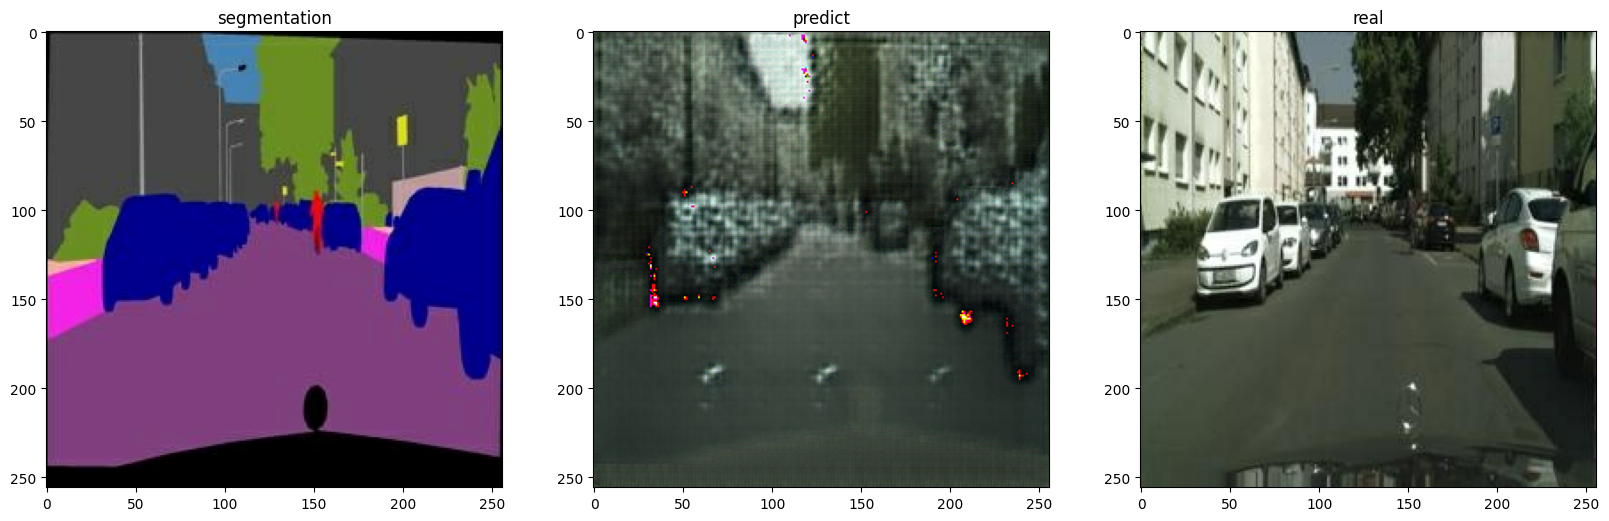

In [58]:
test_ind = 1

val_data_path = 'cityscapes/val/'
f = val_data_path + os.listdir(val_data_path)[test_ind]
seg_img, real_img = load_img(f)

pred = generator(tf.expand_dims(seg_img, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(seg_img)); plt.title('segmentation')
plt.subplot(1,3,2); plt.imshow(pred[0]);plt.title('predict')
plt.subplot(1,3,3); plt.imshow(denormalize(real_img));plt.title('real')

# 회고

- crop, flip진행 
- generator에 U-Net 적용
- descriminator 마지막 출력은 (30,30,1)
- batch size 4로 250번 진행

시간이 굉장히 오래걸려서 epoch를 많이 주는데에 어려움이 있습니다.\
그래서 batch size만 줄이지않고 4개씩 나눠서  gradient update 시켜줬습니다.\
결과적으로 흐릿하지만 real image에서 보이는 물체들의 형태는 볼 수 있게 됐습니다.